In [ ]:
#Testing NetCDF

In [39]:
from netCDF4 import Dataset
import netCDF4 as nc
import geopandas as gpd
import geoplot as gplt
import pandas as pd
from shapely.geometry import Point
import fiona
import folium
import os
import gzip
import glob
import shutil
import seaborn as sns
from datetime import datetime
import matplotlib.pyplot as plt
current_dir=os.getcwd()
current_dir

'/home/angelica/Documents/py_linux/pylocss/src'

Procedure to get the orbits right
1. Load the data (Lake polygons and orbit directory)
    1.1 For lake orbits decompress files (DONE)
    1.2 Get all the atributes for the pass_number and put them in a dataframe
    ##my question, deal with time
2. Get the orbit ID from lake polygon
3. Load the orbit id all available tracks
4. For fields, convert orbit to shapefile
5. Clip orbits
6. calculate water height
7. Plot height accros the lake
8. Plor height in time 
9. Plot height Vs Gauge height

In [40]:
def decompress(zip_nCDir, unzip_Dir=None, extension=None):
    """ Decompress the files and put then in a unzip folder. 
        Input parameters 
            zip_nCDir: Path to directory where data is located 
            unzip_Dir: (Optional) Parth to new directory with the nc unzip files
            extension: NOT IMPLETEMENTED YET for unzip any folder
        Output 
            unzip_Dir where files were unzip
    """
    #https://stackoverflow.com/questions/12902540/read-from-a-gzip-file-in-python
    files = [f for f in os.listdir(zip_nCDir) if os.path.isfile(os.path.join(zip_nCDir, f))]
    if unzip_Dir is None:
        dir_to_move=zip_nCDir+'unzip/'
    else:
        dir_to_move=unzip_Dir
    dirExist=os.path.exists(dir_to_move)
    #print(dir_to_move)
    if not dirExist:
        os.makedirs(dir_to_move)
        
    for f in files:
        with gzip.open(zip_nCDir+f, 'rb') as f_in:
            with open((zip_nCDir+f)[:-3], 'wb') as f_out:
                shutil.copyfileobj(f_in, f_out)
    
    files = [f for f in os.listdir(zip_nCDir) if (os.path.isfile(os.path.join(zip_nCDir, f))&
                                                  (f.endswith('.nc')))]
    for f in files:    
        #print(f)
        
        shutil.move((zip_nCDir+f), (dir_to_move+f))
    return dir_to_move

# Get orbits in a specific pass
def get_orbit_pass(ncDF_main_dir, orbit=None, move=None, where_dir=None):
    list_files = []
    if orbit is not None:
        orbit_form='_'+str(orbit)+'_'
        for root, dirs, files in os.walk(ncDF_main_dir):
            files_orbit = [os.path.join(root,f) for f in files if (os.path.isfile(os.path.join(root, f))&
                                               (orbit_form in f)) ]
            if len(files_orbit)!=0:
#            print(files_orbit)
                list_files.append(files_orbit)
    else: #This is not woking proppertly
        for root, dirs, files in os.walk(ncDF_main_dir):
            files_orbit = [os.path.join(root,f) for f in files if os.path.isfile(os.path.join(root, f))]
            if len(files_orbit)!=0:
                print(files_orbit)
                list_files.append(files_orbit)
    if move is not None:
        if move:
            dirExist=os.path.exists(where_dir)
            #print(dir_to_move)
            if not dirExist:
                os.makedirs(where_dir)
            for f in list_files:    
                shutil.move(f[0], where_dir)
            list_files = [f for f in os.listdir(where_dir) if os.path.isfile(os.path.join(where_dir, f))]
    return list_files

#funtion to get the retracker data in a dataframe

def nCDF2GeoDF(nCDFObject, field_names, coord_fn=None):
    """
        field_names, has all the names posible including coordinate names, by defautl 
        coordinate name are lat, lon and time
        If those are not the name coord_fn is an optional dictionary that can contain the names
        Pending validate because those names has to be equal en in fieldnames
    """
    if coord_fn is not None:
        lat_fn=coord_fn['lat']
        lon_fn=coord_fn['lon']
        time_fn=coord_fn['time']
    else:
        lat_fn='lat'
        lon_fn='lon'
        time_fn='time'
        
    dic_var=dict()
    for var_fn in field_names:
        dic_var[var_fn]=nCDFObject[var_fn][:]
    
    df=pd.DataFrame.from_dict(dic_var)
    df['geometry']=df.apply(lambda x: Point(((float(x[lon_fn])-360), float(x[lat_fn]))), axis=1)
    #Create the shape list dictionary
    df_geo=gpd.GeoDataFrame(df,geometry='geometry')
    print('Datafram',df_geo.head())
    return df_geo


def add_UTC_column(df_geo, time_fn, UTC_fn):
    """ Take the time col, add 2000-01-01 00:00:00 in seconds and convert seconds to date, preserve seconds
        (Using the convention of 1970 start date
        Input 
            df_geo: DataFrame or GeoDataFrame with the time columns to convert
            time_fn: time column in df_geo
            UTC_fn: name of the time column in UTC to add to df_geo
        Return
            df_geo modified 
            
    """
    sec_2000=datetime.strptime('2000-01-01 00:00:00', '%Y-%m-%d %H:%M:%S').timestamp()
    df_geo[UTC_fn]=pd.to_datetime(final_df_geo[time_fn]+sec_2000, unit='s')
    return  df_geo

In [41]:
nCDir='/home/angelica/Dropbox/Research/LOCSS/data_products/compress/'
dir_to_move=decompress(nCDir)
dir_to_move

'/home/angelica/Dropbox/Research/LOCSS/data_products/compress/unzip/'

In [139]:
orbit='011'
orbit_form='_'+str(orbit)+'_'
orbit_form

'_011_'

In [23]:
360-float(2.1)


357.9

In [42]:
lake_path='/home/angelica/Dropbox/Research/LOCSS/Temp/'
lake_file_name='example_lakes_3.shp'
df_lakes_in_orbit=gpd.read_file(lake_path+lake_file_name)
df_ji_orbit=gpd.read_file('/home/angelica/Dropbox/Research/LOCSS/Denis_tracks/2022-02-02_tracks/2022-02-02_tracks/jasoi')
df_lakes_in_orbit
df_ji_orbit

Pass Orbit                                           geometry
0      1     1  MULTILINESTRING ((15.59752 -66.14658, 15.62134...
1      2     1  LINESTRING (-178.55227 66.14660, -178.52844 66...
2      3     2  LINESTRING (-12.72549 -66.14658, -12.70167 -66...
3      4     2  MULTILINESTRING ((153.07745 66.14661, 153.1012...
4      5     3  LINESTRING (-41.07195 -66.14659, -41.04812 -66...
..   ...   ...                                                ...
249  250   125  LINESTRING (-93.51321 66.14660, -93.48938 66.1...
250  251   126  MULTILINESTRING ((72.29043 -66.14659, 72.31425...
251  252   126  LINESTRING (-121.85967 66.14660, -121.83584 66...
252  253   127  MULTILINESTRING ((43.94398 -66.14659, 43.96780...
253  254   127  LINESTRING (-150.20612 66.14661, -150.18230 66...

[254 rows x 3 columns]

In [8]:
df_ji_orbit['Orbit'].unique()

array(['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12',
       '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23',
       '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34',
       '35', '36', '37', '38', '39', '40', '41', '42', '43', '44', '45',
       '46', '47', '48', '49', '50', '51', '52', '53', '54', '55', '56',
       '57', '58', '59', '60', '61', '62', '63', '64', '65', '66', '67',
       '68', '69', '70', '71', '72', '73', '74', '75', '76', '77', '78',
       '79', '80', '81', '82', '83', '84', '85', '86', '87', '88', '89',
       '90', '91', '92', '93', '94', '95', '96', '97', '98', '99', '100',
       '101', '102', '103', '104', '105', '106', '107', '108', '109',
       '110', '111', '112', '113', '114', '115', '116', '117', '118',
       '119', '120', '121', '122', '123', '124', '125', '126', '127'],
      dtype=object)

In [43]:
#get the required orbit 
files = [f for f in os.listdir(dir_to_move) if os.path.isfile(os.path.join(dir_to_move, f))]



field_names=['lat','lon','time', 'ice_range_ku', #ice1 solution
            'alt',
             'topography',
            'range_ice3_ku', #PISTACH solution
            'model_wet_tropo_corr', #Wet Troposphere Correction: is not optimal over non ocean areas due to a possibly inaccurate knowledge of the atmosphere thickness above each altimeter data point
            'model_wet_tropo_corr_direct_sol', #see for updates on its use
            'model_dry_tropo_corr', #Dry toposphere correction standard
            'model_dry_tropo_corr_direct_sol',  #Dry toposphere correction modeled 
            'iono_corr_gim_ku', #Ionosphere Correction
            'sea_state_bias_ku', #Sea State Bias Correction for range_ku
            'sea_state_bias_oce3_ku' #Sea State Bias Correction for range_oce3_ku
            ]
meta_var=['mission_name', 'altimeter_sensor_name', 'pass_number','equator_time']
final_df_geo=gpd.GeoDataFrame()
for f in files:
    #print(dir_to_move+f)
    nCDF_data = nc.Dataset((dir_to_move+f))
    df_geo=nCDF2GeoDF(nCDF_data, field_names)
    for mv in meta_var:
        df_geo[mv]=nCDF_data.__dict__[mv]
    final_df_geo=final_df_geo.append(df_geo)

final_df_geo.set_crs(epsg=4326, inplace=True)

    
    


/home/angelica/.conda/envs/geo_env/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:122: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


Datafram          lat         lon          time  ice_range_ku           alt  \
0  19.218037  254.539092  2.704785e+08  1.341734e+06  1.341706e+06   
1  19.220505  254.540116  2.704785e+08  1.341735e+06  1.341707e+06   
2  19.222974  254.541141  2.704785e+08  1.341735e+06  1.341707e+06   
3  19.225442  254.542165  2.704785e+08  1.341735e+06  1.341708e+06   
4  19.227911  254.543190  2.704785e+08  1.341736e+06  1.341708e+06   

   topography  range_ice3_ku  model_wet_tropo_corr  \
0         NaN   1.341734e+06               -0.2942   
1         NaN   1.341735e+06               -0.2941   
2         NaN   1.341735e+06               -0.2940   
3         NaN   1.341736e+06               -0.2939   
4         NaN   1.341736e+06               -0.2939   

   model_wet_tropo_corr_direct_sol  model_dry_tropo_corr  \
0                              NaN               -2.3121   
1                              NaN               -2.3121   
2                              NaN               -2.3121   
3    

<ipython-input-43-10229b137426>:26: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  final_df_geo=final_df_geo.append(df_geo)
/home/angelica/.conda/envs/geo_env/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:122: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


Datafram          lat         lon          time  ice_range_ku           alt  \
0  19.217674  254.537621  2.713353e+08  1.341834e+06  1.341806e+06   
1  19.220143  254.538645  2.713353e+08  1.341834e+06  1.341806e+06   
2  19.222611  254.539670  2.713353e+08  1.341835e+06  1.341807e+06   
3  19.225080  254.540694  2.713353e+08  1.341835e+06  1.341807e+06   
4  19.227548  254.541719  2.713353e+08  1.341835e+06  1.341807e+06   

   topography  range_ice3_ku  model_wet_tropo_corr  \
0         NaN   1.341834e+06               -0.3459   
1         NaN   1.341834e+06               -0.3458   
2         NaN   1.341835e+06               -0.3457   
3         NaN   1.341835e+06               -0.3456   
4         NaN   1.341835e+06               -0.3456   

   model_wet_tropo_corr_direct_sol  model_dry_tropo_corr  \
0                              NaN                -2.306   
1                              NaN                -2.306   
2                              NaN                -2.306   
3    

<ipython-input-43-10229b137426>:26: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  final_df_geo=final_df_geo.append(df_geo)
/home/angelica/.conda/envs/geo_env/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:122: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


Datafram          lat         lon          time  ice_range_ku           alt  \
0  19.216818  254.540684  2.696218e+08  1.341654e+06  1.341626e+06   
1  19.219287  254.541708  2.696218e+08  1.341654e+06  1.341626e+06   
2  19.221755  254.542733  2.696218e+08  1.341655e+06  1.341627e+06   
3  19.224224  254.543758  2.696218e+08  1.341655e+06  1.341627e+06   
4  19.226692  254.544782  2.696218e+08  1.341656e+06  1.341628e+06   

   topography  range_ice3_ku  model_wet_tropo_corr  \
0         NaN   1.341654e+06               -0.3431   
1         NaN   1.341655e+06               -0.3431   
2         NaN   1.341655e+06               -0.3432   
3         NaN   1.341655e+06               -0.3432   
4         NaN   1.341656e+06               -0.3431   

   model_wet_tropo_corr_direct_sol  model_dry_tropo_corr  \
0                              NaN               -2.3118   
1                              NaN               -2.3118   
2                              NaN               -2.3118   
3    

<ipython-input-43-10229b137426>:26: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  final_df_geo=final_df_geo.append(df_geo)


lat         lon          time  ice_range_ku           alt  \
0      19.218037  254.539092  2.704785e+08  1.341734e+06  1.341706e+06   
1      19.220505  254.540116  2.704785e+08  1.341735e+06  1.341707e+06   
2      19.222974  254.541141  2.704785e+08  1.341735e+06  1.341707e+06   
3      19.225442  254.542165  2.704785e+08  1.341735e+06  1.341708e+06   
4      19.227911  254.543190  2.704785e+08  1.341736e+06  1.341708e+06   
...          ...         ...           ...           ...           ...   
11531  66.088462  326.149717  2.696231e+08  1.354236e+06  1.354291e+06   
11532  66.088644  326.156173  2.696231e+08  1.354236e+06  1.354291e+06   
11533  66.088827  326.162629  2.696231e+08  1.354236e+06  1.354291e+06   
11534  66.089009  326.169085  2.696231e+08  1.354236e+06  1.354291e+06   
11535  66.089190  326.175542  2.696231e+08  1.354236e+06  1.354291e+06   

       topography  range_ice3_ku  model_wet_tropo_corr  \
0             NaN   1.341734e+06               -0.2942   
1             NaN   1.341735e+06               -0.2941   
2             NaN   1.341735e+06               -0.2940   
3             NaN   1.341736e+06               -0.2939   
4             NaN   1.341736e+06               -0.2939   
...           ...            ...                   ...   
11531         NaN   1.354236e+06               -0.0761   
11532         NaN   1.354236e+06               -0.0761   
11533         NaN   1.354236e+06               -0.0762   
11534         NaN   1.354236e+06               -0.0762   
11535         NaN   1.354236e+06               -0.0763   

       model_wet_tropo_corr_direct_sol  model_dry_tropo_corr  \
0                                  NaN               -2.3121   
1                                  NaN               -2.3121   
2                                  NaN               -2.3121   
3                                  NaN               -2.3121   
4                                  NaN               -2.3121   
...                                ...                   ...   
11531                              NaN               -2.3002   
11532                              NaN               -2.3002   
11533                              NaN               -2.3002   
11534                              NaN               -2.3002   
11535                              NaN               -2.3002   

       model_dry_tropo_corr_direct_sol  iono_corr_gim_ku  sea_state_bias_ku  \
0                                  NaN           -0.0191            -0.0731   
1                                  NaN           -0.0191            -0.0724   
2                                  NaN           -0.0191            -0.0716   
3                                  NaN           -0.0191            -0.0709   
4                                  NaN           -0.0191            -0.0702   
...                                ...               ...                ...   
11531                              NaN           -0.0189            -0.2985   
11532                              NaN           -0.0189            -0.2986   
11533                              NaN           -0.0189            -0.2854   
11534                              NaN           -0.0189            -0.2722   
11535                              NaN           -0.0189            -0.2591   

       sea_state_bias_oce3_ku                     geometry  mission_name  \
0                         NaN  POINT (-105.46091 19.21804)  OSTM/Jason-2   
1                         NaN  POINT (-105.45988 19.22050)  OSTM/Jason-2   
2                         NaN  POINT (-105.45886 19.22297)  OSTM/Jason-2   
3                         NaN  POINT (-105.45784 19.22544)  OSTM/Jason-2   
4                         NaN  POINT (-105.45681 19.22791)  OSTM/Jason-2   
...                       ...                          ...           ...   
11531                     NaN   POINT (-33.85028 66.08846)  OSTM/Jason-2   
11532                     NaN   POINT (-33.84383 66.08864)  OSTM/Jason-2   
11533                    

In [44]:
final_df_geo.columns
#final_df_geo['time'].head()
#final_df_geo['equator_time'].unique()
#Convert start date of altimeter to seg
final_df_geo=add_UTC_column(final_df_geo, 'time','UTC_time')
final_df_geo.head()

lat         lon          time  ice_range_ku           alt  \
0  19.218037  254.539092  2.704785e+08  1.341734e+06  1.341706e+06   
1  19.220505  254.540116  2.704785e+08  1.341735e+06  1.341707e+06   
2  19.222974  254.541141  2.704785e+08  1.341735e+06  1.341707e+06   
3  19.225442  254.542165  2.704785e+08  1.341735e+06  1.341708e+06   
4  19.227911  254.543190  2.704785e+08  1.341736e+06  1.341708e+06   

   topography  range_ice3_ku  model_wet_tropo_corr  \
0         NaN   1.341734e+06               -0.2942   
1         NaN   1.341735e+06               -0.2941   
2         NaN   1.341735e+06               -0.2940   
3         NaN   1.341736e+06               -0.2939   
4         NaN   1.341736e+06               -0.2939   

   model_wet_tropo_corr_direct_sol  model_dry_tropo_corr  \
0                              NaN               -2.3121   
1                              NaN               -2.3121   
2                              NaN               -2.3121   
3                              NaN               -2.3121   
4                              NaN               -2.3121   

   model_dry_tropo_corr_direct_sol  iono_corr_gim_ku  sea_state_bias_ku  \
0                              NaN           -0.0191            -0.0731   
1                              NaN           -0.0191            -0.0724   
2                              NaN           -0.0191            -0.0716   
3                              NaN           -0.0191            -0.0709   
4                              NaN           -0.0191            -0.0702   

   sea_state_bias_oce3_ku                     geometry  mission_name  \
0                     NaN  POINT (-105.46091 19.21804)  OSTM/Jason-2   
1                     NaN  POINT (-105.45988 19.22050)  OSTM/Jason-2   
2                     NaN  POINT (-105.45886 19.22297)  OSTM/Jason-2   
3                     NaN  POINT (-105.45784 19.22544)  OSTM/Jason-2   
4                     NaN  POINT (-105.45681 19.22791)  OSTM/Jason-2   

  altimeter_sensor_name  pass_number                equator_time  \
0            Poseidon-3          143  2008-07-27 12:49:12.688000   
1            Poseidon-3          143  2008-07-27 12:49:12.688000   
2            Poseidon-3          143  2008-07-27 12:49:12.688000   
3            Poseidon-3          143  2008-07-27 12:49:12.688000   
4            Poseidon-3          143  2008-07-27 12:49:12.688000   

                       UTC_time  
0 2008-07-27 17:55:46.259737856  
1 2008-07-27 17:55:46.310745088  
2 2008-07-27 17:55:46.361753088  
3 2008-07-27 17:55:46.412761088  
4 2008-07-27 17:55:46.463768832

In [45]:
final_df_geo['equator_time'].unique()

array(['2008-07-27 12:49:12.688000', '2008-08-06 10:47:44.230000',
       '2008-07-17 14:50:41.015000'], dtype=object)

In [50]:
final_df_geo.head()

lat         lon          time  ice_range_ku           alt  \
0  19.218037  254.539092  2.704785e+08  1.341734e+06  1.341706e+06   
1  19.220505  254.540116  2.704785e+08  1.341735e+06  1.341707e+06   
2  19.222974  254.541141  2.704785e+08  1.341735e+06  1.341707e+06   
3  19.225442  254.542165  2.704785e+08  1.341735e+06  1.341708e+06   
4  19.227911  254.543190  2.704785e+08  1.341736e+06  1.341708e+06   

   topography  range_ice3_ku  model_wet_tropo_corr  \
0         NaN   1.341734e+06               -0.2942   
1         NaN   1.341735e+06               -0.2941   
2         NaN   1.341735e+06               -0.2940   
3         NaN   1.341736e+06               -0.2939   
4         NaN   1.341736e+06               -0.2939   

   model_wet_tropo_corr_direct_sol  model_dry_tropo_corr  \
0                              NaN               -2.3121   
1                              NaN               -2.3121   
2                              NaN               -2.3121   
3                              NaN               -2.3121   
4                              NaN               -2.3121   

   model_dry_tropo_corr_direct_sol  iono_corr_gim_ku  sea_state_bias_ku  \
0                              NaN           -0.0191            -0.0731   
1                              NaN           -0.0191            -0.0724   
2                              NaN           -0.0191            -0.0716   
3                              NaN           -0.0191            -0.0709   
4                              NaN           -0.0191            -0.0702   

   sea_state_bias_oce3_ku                     geometry  mission_name  \
0                     NaN  POINT (-105.46091 19.21804)  OSTM/Jason-2   
1                     NaN  POINT (-105.45988 19.22050)  OSTM/Jason-2   
2                     NaN  POINT (-105.45886 19.22297)  OSTM/Jason-2   
3                     NaN  POINT (-105.45784 19.22544)  OSTM/Jason-2   
4                     NaN  POINT (-105.45681 19.22791)  OSTM/Jason-2   

  altimeter_sensor_name  pass_number                equator_time  \
0            Poseidon-3          143  2008-07-27 12:49:12.688000   
1            Poseidon-3          143  2008-07-27 12:49:12.688000   
2            Poseidon-3          143  2008-07-27 12:49:12.688000   
3            Poseidon-3          143  2008-07-27 12:49:12.688000   
4            Poseidon-3          143  2008-07-27 12:49:12.688000   

                       UTC_time  
0 2008-07-27 17:55:46.259737856  
1 2008-07-27 17:55:46.310745088  
2 2008-07-27 17:55:46.361753088  
3 2008-07-27 17:55:46.412761088  
4 2008-07-27 17:55:46.463768832

In [54]:
dfg=final_df_geo.loc[final_df_geo['equator_time']=='2008-07-27 12:49:12.688000'].copy()
dfg['UTC_time']=dfg['UTC_time'].dt.strftime('%Y-%m-%d %H:%M:%S')
dfg.shape
dfg.to_file(lake_path+'sample_orbit_143_2.shp')
#mask=dfg.within(df_lakes_in_orbit)
#df_track=dfg.loc[mask]
#df_track

/home/angelica/.conda/envs/geo_env/lib/python3.9/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
<ipython-input-54-f47e4888b37f>:4: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  dfg.to_file(lake_path+'sample_orbit_143_2.shp')


In [57]:
df_lakes_in_orbit.columns
dfg.head()

lat         lon          time  ice_range_ku           alt  \
0  19.218037  254.539092  2.704785e+08  1.341734e+06  1.341706e+06   
1  19.220505  254.540116  2.704785e+08  1.341735e+06  1.341707e+06   
2  19.222974  254.541141  2.704785e+08  1.341735e+06  1.341707e+06   
3  19.225442  254.542165  2.704785e+08  1.341735e+06  1.341708e+06   
4  19.227911  254.543190  2.704785e+08  1.341736e+06  1.341708e+06   

   topography  range_ice3_ku  model_wet_tropo_corr  \
0         NaN   1.341734e+06               -0.2942   
1         NaN   1.341735e+06               -0.2941   
2         NaN   1.341735e+06               -0.2940   
3         NaN   1.341736e+06               -0.2939   
4         NaN   1.341736e+06               -0.2939   

   model_wet_tropo_corr_direct_sol  model_dry_tropo_corr  \
0                              NaN               -2.3121   
1                              NaN               -2.3121   
2                              NaN               -2.3121   
3                              NaN               -2.3121   
4                              NaN               -2.3121   

   model_dry_tropo_corr_direct_sol  iono_corr_gim_ku  sea_state_bias_ku  \
0                              NaN           -0.0191            -0.0731   
1                              NaN           -0.0191            -0.0724   
2                              NaN           -0.0191            -0.0716   
3                              NaN           -0.0191            -0.0709   
4                              NaN           -0.0191            -0.0702   

   sea_state_bias_oce3_ku                     geometry  mission_name  \
0                     NaN  POINT (-105.46091 19.21804)  OSTM/Jason-2   
1                     NaN  POINT (-105.45988 19.22050)  OSTM/Jason-2   
2                     NaN  POINT (-105.45886 19.22297)  OSTM/Jason-2   
3                     NaN  POINT (-105.45784 19.22544)  OSTM/Jason-2   
4                     NaN  POINT (-105.45681 19.22791)  OSTM/Jason-2   

  altimeter_sensor_name  pass_number                equator_time  \
0            Poseidon-3          143  2008-07-27 12:49:12.688000   
1            Poseidon-3          143  2008-07-27 12:49:12.688000   
2            Poseidon-3          143  2008-07-27 12:49:12.688000   
3            Poseidon-3          143  2008-07-27 12:49:12.688000   
4            Poseidon-3          143  2008-07-27 12:49:12.688000   

              UTC_time  
0  2008-07-27 17:55:46  
1  2008-07-27 17:55:46  
2  2008-07-27 17:55:46  
3  2008-07-27 17:55:46  
4  2008-07-27 17:55:46

In [55]:

m=dfg['geometry'].explore(name='orbit')
#dfg['geometry'].explore(m=m, name='2008_0827')

df_lakes_in_orbit.explore(column='Hylak_id',
                          m=m, #add to the map
                          tooltip='Hylak_id',
                          popup=True, # show all values in popup (on click)
                          tiles="CartoDB positron", # use "CartoDB positron" tiles
                          cmap="Set1", # use "Set1" matplotlib colormap
                          name='lakes'
                          )

folium.TileLayer('Stamen Toner', control=True).add_to(m)  # use folium to add alternative tiles
folium.LayerControl().add_to(m)  # use folium to add layer control
m


In [227]:
final_df_geo[final_df_geo.index.duplicated()]
final_df_geo.shape

(54575, 18)

In [124]:
#df_geo['geometry'].head()

#How to get the metadata on netCDF
meta_var=['mission_name', 'altimeter_sensor_name', 'pass_number','equator_time']
#nCDF_data.__dict__

nCDF_data['time'][:]

masked_array(data=[2.69621835e+08, 2.69621835e+08, 2.69621835e+08, ...,
                   2.69623095e+08, 2.69623095e+08, 2.69623095e+08],
             mask=False,
       fill_value=1e+20)

In [35]:
nCDir='/home/angelica/Dropbox/Research/LOCSS/data_products/compress/'

files = [f for f in os.listdir(nCDir) if os.path.isfile(os.path.join(nCDir, f))]

#for f in files:
#    print(f)
#    print(f[:-3])

nCDFs=dict()
for f in files:
    print(nCDir+f[:-3])
#    with gzip.open(nCDir+f, 'rb') as f_in:
#        with open((nCDir+f)[:-3], 'wb') as f_out:
#            shutil.copyfileobj(f_in, f_out)
    nCDF_data = nc.Dataset((nCDir+f))
    nCDFs[f]=nCDF_data
#    print(nCDir+f)
#    print(nCDF_data.dimensions['time'])
#1. Unzip
#2. Read
    
#nCDF_data = nc.Dataset("/home/angelica/Downloads/JA2_IPH_2PTP002_001_20080721_234556_20080722_001448.nc")
#print(nCDF_data.data_model) #Print the type of data model
#print('All metadata\n',nCDF_data)
#print('All metadata 2 with dictionary \n',nCDF_data.__dict__)

/home/angelica/Dropbox/Research/LOCSS/data_products/compress/JA2_IPH_2PTP003_143_20080806_105417_20080806_111518.nc
/home/angelica/Dropbox/Research/LOCSS/data_products/compress/JA2_IPH_2PTP002_143_20080727_125546_20080727_131646.nc
/home/angelica/Dropbox/Research/LOCSS/data_products/compress/JA2_IPH_2PTP001_143_20080717_145714_20080717_151815.nc


In [21]:

    
    
nCDF_data['swh_ku']
nCDF_data['swh_ku'][:]
nCDF_data['lat'][:]
nCDF_data['lon'][:]
nCDF_data['time'][:]
print(nCDF_data['swh_ku'].dimensions, nCDF_data['swh_ku'].shape)
print(nCDF_data['lat'].dimensions, nCDF_data['lat'].shape)
print(nCDF_data['lon'].dimensions, nCDF_data['lon'].shape)

var_get='swh_ku'
time_var='time'
lat='lat'
lon='lon'

#function
#Get lat and long
lats= nCDF_data[lat][:]
lons= nCDF_data[lon][:]
swhs= nCDF_data[var_get][:]
time= nCDF_data[time_var][:]
#print(len(lats))
#create list of pair coordinates
full_orbit=[]

for  i in range(0,len(lats)):
    full_orbit.append([lats[i],lons[i], time[i], swhs[i]])

df=pd.DataFrame(full_orbit, columns=[lat,lon,time_var,var_get])
df['geometry']=df.apply(lambda x: Point((float(x[lat]), float(x[lon]))), axis=1)
#Create the shape list dictionary

df_geo=gpd.GeoDataFrame(df,geometry='geometry')
print(df_geo.head())
df_geo.plot()

In [12]:
#access the dimmensions
for dim in nCDF_data.dimensions.values():
    print(dim)
    
print(nCDF_data.dimensions['time'])

<class 'netCDF4._netCDF4.Dimension'>: name = 'time', size = 25902
<class 'netCDF4._netCDF4.Dimension'>: name = 'time', size = 25902


In [62]:
#Access variables 
i=1
for var in nCDF_data.variables: #If I use only variables. I get the names  
    #print('\n***Variable Name: '+str(i)+'****:',var)
    #print('***Variable values: '+str(i)+'****\n',nCDF_data[var])
    i=i+1
    
nCDF_data

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF3_CLASSIC data model, file format NETCDF3):
    Conventions: CF-1.1
    title: IGDR - PISTACH high frequency Hydrological dataset
    institution: CNES/CLS
    source: radar altimeter
    history: 2009-04-15 19:51:50 : Creation
    contact: TBD
    references: TBD
    reference_document: OSTM/Jason-2 Products Handbook,CLS-DOS-NT-08.096 and PISTACH Jason-2 Product Handbook,  CLS-DOS-NT-XX.XXX
    mission_name: OSTM/Jason-2
    altimeter_sensor_name: Poseidon-3
    radiometer_sensor_name: AMR
    doris_sensor_name: DGXX
    cycle_number: 2
    absolute_rev_number: 228
    pass_number: 1
    absolute_pass_number: 255
    equator_time: 2008-07-21 23:46:43.540000
    equator_longitude: 99.93
    first_meas_time: 2008-07-21 23:45:56.163119
    last_meas_time: 2008-07-22 00:14:48.398675
    ellipsoid_axis: 6378136.3
    ellipsoid_flattening: 0.0033528131778969143
    dimensions(sizes): time(25902)
    variables(dimensions): float64 time(tim

('time',) (25902,)
('time',) (25902,)
('time',) (25902,)


/home/angelica/.conda/envs/geo_env/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:122: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


        lat        lon          time swh_ku               geometry
0 -2.323090  99.097720  2.699992e+08  2.604  POINT (-2.323 99.098)
1 -2.320589  99.098614  2.699992e+08  3.532  POINT (-2.321 99.099)
2 -2.318088  99.099507  2.699992e+08  2.141  POINT (-2.318 99.100)
3 -2.315587  99.100400  2.699992e+08  2.944  POINT (-2.316 99.100)
4 -2.313086  99.101294  2.699992e+08   2.99  POINT (-2.313 99.101)


<AxesSubplot:>

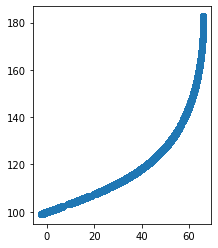

In [71]:
#function 


nCDF_data['swh_ku']
nCDF_data['swh_ku'][:]
nCDF_data['lat'][:]
nCDF_data['lon'][:]
nCDF_data['time'][:]
print(nCDF_data['swh_ku'].dimensions, nCDF_data['swh_ku'].shape)
print(nCDF_data['lat'].dimensions, nCDF_data['lat'].shape)
print(nCDF_data['lon'].dimensions, nCDF_data['lon'].shape)

var_get='swh_ku'
time_var='time'
lat='lat'
lon='lon'

#function
#Get lat and long
lats= nCDF_data[lat][:]
lons= nCDF_data[lon][:]
swhs= nCDF_data[var_get][:]
time= nCDF_data[time_var][:]
#print(len(lats))
#create list of pair coordinates
full_orbit=[]

for  i in range(0,len(lats)):
    full_orbit.append([lats[i],lons[i], time[i], swhs[i]])

df=pd.DataFrame(full_orbit, columns=[lat,lon,time_var,var_get])
df['geometry']=df.apply(lambda x: Point((float(x[lat]), float(x[lon]))), axis=1)
#Create the shape list dictionary

df_geo=gpd.GeoDataFrame(df,geometry='geometry')
print(df_geo.head())
df_geo.plot()
#df.to_file('MyGeometries.shp', driver='ESRI Shapefile')

In [57]:
data=[]
data.append([1,2, 'Lola'])
data.append([2,2, 'Pepe'])
data
df=pd.DataFrame(data, columns=['Nu1', 'Nu2', 'Nombre'])
df

Nu1  Nu2 Nombre
0    1    2   Lola
1    2    2   Pepe